# Hand classification

This notebook allows us to work with neural network-based hand classification models (*using Tensorflow 2*) with a more **user-friendly interface**, without the need to make any changes to the code. The task consists of given a hand, predicting the gender of the individual.

Although the GPU can speed up the inference, we can work with the CPU without problems, as the inference time for an image is very low even on the CPU (a few microseconds).

    Author: @AAitorG

In [ ]:
#@title  { display-mode: "form" }
#@markdown <h3> Utilities + Download & Load model (run this!) </h3>

!pip install tensorflow==2.12 keras==2.12

from PIL import Image
from skimage.measure import label, regionprops
import numpy as np

def get_just_hand(np_img, image_size=256):

    props = regionprops(np_img) # (min_row, min_col, max_row, max_col) -- [min; max)
    min_row, min_col, max_row, max_col = props[0]['bbox']
    hand_cols = max_col - min_col
    remain = hand_cols - image_size
    left = True
    N_col = np_img.shape[1]

    if remain < 0:
        # hand is smaller so, we need to add extra padding
        remain = abs(remain) # now just count remaining columns
        for i in range(remain):
            if left:
                if min_col > 0: min_col -= 1
                elif max_col+1 < N_col: max_col += 1
                else: print('ERROR: image is not big enough')
            else:
                if max_col+1 < N_col: max_col += 1
                elif min_col > 0: min_col -= 1
                else: print('ERROR')
            left = not left
    elif remain > 0:
        # hand is bigger, so we need to cut a bit more
        for i in range(remain):
            if left: min_col += 1
            else: max_col -= 1
            left = not left

    return np_img[:, min_col:max_col]

def load_and_preprocess_image(img_path, rotate_180=False, white_hand=True, output_img_size=256):
    # The image is the binary mask

    image = Image.open(img_path)
    # Convert (RGBA,...) images to RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    width, height = image.size
    shorter_h = height <= width
    factor = output_img_size/height if shorter_h else output_img_size/width
    new_width, new_height = round(width*factor), round(height*factor)
    image = image.resize((new_width, new_height), Image.NEAREST) # resize equally height and width until shortest side is 256px long

    if not shorter_h:
        image = image.transpose(Image.ROTATE_90)

    # labeled img - cropp by bbox
    if rotate_180:
        image = image.transpose(Image.ROTATE_180) # rock
    np_img = (np.array(image)[:,:,0] > 128).astype(np.uint8)
    if not white_hand:
        np_img = 1-np_img

    if height != width:
        np_img = get_just_hand(np_img, output_img_size)

    np_img = np_img * 255
    np_img = np.expand_dims(np_img, axis=-1)
    np_img = np.concatenate([np_img, np_img, np_img], axis=-1)
    gt_img = Image.fromarray(np_img.astype(np.uint8))

    if not shorter_h:
        gt_img = gt_img.transpose(Image.ROTATE_270)
    return np.array(gt_img)

# UPLOAD
from google.colab import files
#print("Upload model (.h5 format):")
#uploaded = files.upload()
#model_name = list(uploaded.keys())[0]
#print('\nmodel_name:', model_name)

# DOWNLOAD
import os
model_name = './hand-classifier-weights-1neuron-effnetv2S.h5'
if not os.path.exists(model_name):
    !wget 'https://www.dropbox.com/s/5jmc2a0bp19tu7c/hand-classifier-weights-1neuron-effnetv2S.h5?dl=0' -O './hand-classifier-weights-1neuron-effnetv2S.h5'

# LOAD model
from tensorflow.keras.models import load_model
try:
    if model != None:
        del model
except:
    pass
model = load_model(model_name)
print('Model loaded')

--2023-03-14 11:29:29--  https://www.dropbox.com/s/5jmc2a0bp19tu7c/hand-classifier-weights-1neuron-effnetv2S.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/5jmc2a0bp19tu7c/hand-classifier-weights-1neuron-effnetv2S.h5 [following]
--2023-03-14 11:29:29--  https://www.dropbox.com/s/raw/5jmc2a0bp19tu7c/hand-classifier-weights-1neuron-effnetv2S.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb3d20e18dc6043a47dcaefb432.dl.dropboxusercontent.com/cd/0/inline/B4OwY2Y2WeJWrBAshZRHy6biWog_r8EAnNxmhO7e5kEIYPf8Oc7a6REEFv9ZZJwE1qIpWxpZpfuvni7TErYw7LPgu5u09ImV5NoBsQS-KxryMPrm0wbVdMZzxtCcnGqUmjauoZZQO2n1zF1Cvjpa0FIHglmsmjb5j9WkIPc6yQnGcA/file# [following]
--2023-03-14 11:29:29--  https://ucb3d20e18dc6043a47dcaefb432.dl.dropboxusercon

Upload image:


Saving 0_Hand_0000086.png to 0_Hand_0000086.png
Uploaded filename: 0_Hand_0000086.png
Uploaded image:


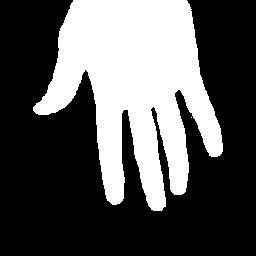

In [ ]:
#@title  { display-mode: "form" }
#@markdown <h3> Upload image </h3>

#@markdown *Note: You can run this cell as many times as you need.*
print("Upload image:")
uploaded = files.upload()
image_name = list(uploaded.keys())[0]
print('Uploaded filename:', image_name)
print("Uploaded image:")
Image.open(image_name)

<h1><center> Preprocessing </h1>

Preprocessing includes: centring the hand, resizing and cropping the image to 256x256.

Before the image is given to the model, the image must look as shown in Fig. 1. In summary, the important features to consider are:

1.   The image must include the semantic segmentation of a single hand.
2.   The hand must be white and the background black.
3.   The fingers must face downwards.

The 2nd and 3rd point can be easily corrected by using the checkboxes in the following cell or form. The `_image_name` is the file name of the image we want to modify and use, if we leave this option empty, the last uploaded image will be used by default.

Once the form is completed, we only have to run the cell and continue.

___

*Note: The `_image_name` file names are only valid if those images have been previously uploaded during the same session. Once the machine is switched off, previously uploaded data will be lost.*

---


<body>
<center>
<cropped>
<img src="https://www.dropbox.com/s/fm9x4iiyigve2ux/Hand%20segmentation%20example.png?dl=1" alt="Binary label image" width="256" >
</cropped>
<figcaption>(Fig. 1) Example of semantic segmentation of a hand. This example contains a female hand.</figcaption>
</body>


Make sure the hand is white and the fingers are facing downwards in the following image:

 0_Hand_0000086.png
 (256, 256, 3)


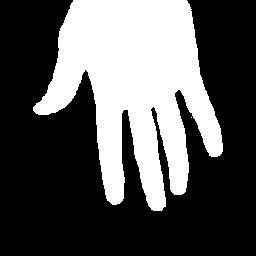

In [ ]:
#@title { display-mode: "form" }
#@markdown <h1> Loading and Pre-processing the image </h1>
#@markdown Once the pre-processed image looks like the image in the given example (Fig. 1),
#@markdown we can go ahead and make the prediction using the model.

#@markdown ---
import matplotlib.pyplot as plt

sigmoid = lambda x : 1/(1 + np.exp(-x))
label2tag = {0:"Female", 1:"Male"}

#@markdown Check if the hand is black in the uploaded image.
hand_is_black = False #@param {type:"boolean"}
#@markdown Check whether the fingers are pointing upwards in the uploaded image.
fingers_are_facing_upwards = False #@param {type:"boolean"}

#@markdown (OPTIONAL) Write the filename of the image to be used.
#@markdown
#@markdown  * *By default: last uploaded image will be used.*
_image_name = '' #@param {type:"string"}
if _image_name != '': image_name = _image_name

img = load_and_preprocess_image(image_name, rotate_180=fingers_are_facing_upwards,
                                white_hand=not hand_is_black)
print("Make sure the hand is white and the fingers are facing downwards in the following image:")
print('\n', image_name)
print('', img.shape)

Image.fromarray(img)

The `Predicted value` shows the output of the model after applying the
sigmoidal function to it. The value has a $[0,1]$ range where $0$ means the
predicted class is "*Female*" and $1$ means that the predicted class is "*Male*".

With this in mind we will consider that the `Prediction`
or predicted class will be "*Male*" if `Predicted value` > 0.5
otherwise, the predicted class will be "*Female*".

Finally, we will consider the level of `Confidence` of the predicted class as:

$$ Confidence = \left\{ \begin{array}{cl}
Predicted Value & if \ \ \ \ Predicted Value > 0.5 \\
1-Predicted Value & else
\end{array} \right. $$

The confidence level of each class has a range [0, 1], where $0$ means that there is no confidence, and $1$ means that there is very high confidence that it belongs to that class. Note that both probabilities are complementary

$$p + (1-p) = 1$$

where $p$ is the probability of belonging to the class "*Male*" and $(1-p)$ is the probability of belonging to the class "*Female*". Therefore, the predicted class will always have at least $0.5$ confidence.

Input: 0_Hand_0000086.png


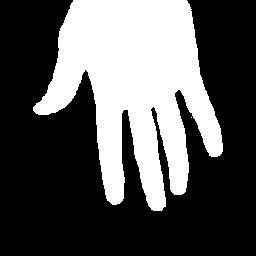


Predicted value: 0.20841 
------------------------------
Prediction: Female
Confidence: 0.79159


In [ ]:
#@title  { display-mode: "form" }
#@markdown <h3> Use the model and make a prediction </h3>
prediction = model.predict_on_batch(np.array([img]))
pred_val = sigmoid(prediction[0][0])
pred_class = 1 if pred_val>0.5 else 0
conf = pred_val if pred_val>0.5 else 1-pred_val

print('Input:', image_name)
Image.fromarray(img).show()
print('\nPredicted value:', round(pred_val, 5), '\n' + '-'*30)
print('Prediction:', label2tag[pred_class])
print('Confidence:', round(conf, 5))